In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.models.resnet import resnet34, resnet18  # Using a basic, small ResNet variant
from torch import nn

# Transformation for CIFAR-10 images
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Standard normalization for CIFAR-10
# ])

# Transforms from: https://colab.research.google.com/github/Rakshit-Shetty/Resnet-Implementation/blob/master/ResNet_Implementation_on_CIFAR10.ipynb#scrollTo=l5WmV1je_1kr
#Image augmentation is used to train the model
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),

])
#Only the data is normalaized we do not need to augment the test data
transform_test = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data/train', train=True, download=True,
                                        transform=transform_train)
trainloader = DataLoader(trainset, batch_size=64, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data/test', train=False, download=True,
                                        transform=transform_test)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

print(trainset)
print(testset)
print(f'Classes: {classes}')

# Modify ResNet for CIFAR-10 (assume using resnet18)
model = resnet34()
model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)  # Adjusting first conv layer to accept 32x32 input
model.maxpool = nn.Identity()  # Remove maxpool to keep dimensionality
model.fc = nn.Linear(model.fc.in_features, 10)  # Adjusting final fully connected layer for 10 classes

# Assuming use of a GPU if available
device = torch.device("mps")
model.to(device)

def evaluate_model(testing_model, dataloader, suppress_output=False):
    testing_model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = testing_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    if not suppress_output:
        print(f'Accuracy of the model on the test images: {accuracy}%')
    return accuracy

Files already downloaded and verified
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data/train
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./data/test
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [2]:
import torch.optim as optim
from torch import nn

# Set up the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# Define number of epochs
num_epochs = 20

for epoch in range(num_epochs):  # Loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # Get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward and optimize
        loss.backward()
        optimizer.step()

        # Print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # Print every 200 mini-batches
            print(f'Epoch {epoch + 1}, Batch {i + 1}: Loss: {running_loss / 200:.4f}')
            print(f'\tAcc (Test data): {evaluate_model(model, testloader, suppress_output=True)}')
            running_loss = 0.0

print('Finished Training')
# torch.save(model.state_dict(), "state")

# Evaluate the model
evaluate_model(model, testloader)


Epoch 1, Batch 200: Loss: 2.0771
	Acc (Test data): 29.97
Epoch 1, Batch 400: Loss: 1.8877
	Acc (Test data): 36.06
Epoch 1, Batch 600: Loss: 1.7357
	Acc (Test data): 33.29
Epoch 2, Batch 200: Loss: 1.6389
	Acc (Test data): 43.06
Epoch 2, Batch 400: Loss: 1.5584
	Acc (Test data): 44.64
Epoch 2, Batch 600: Loss: 1.5385
	Acc (Test data): 45.19
Epoch 3, Batch 200: Loss: 1.4291
	Acc (Test data): 48.75
Epoch 3, Batch 400: Loss: 1.3942
	Acc (Test data): 49.83
Epoch 3, Batch 600: Loss: 1.3615
	Acc (Test data): 53.64
Epoch 4, Batch 200: Loss: 1.2955
	Acc (Test data): 49.76
Epoch 4, Batch 400: Loss: 1.2561
	Acc (Test data): 55.88
Epoch 4, Batch 600: Loss: 1.2668
	Acc (Test data): 56.06
Epoch 5, Batch 200: Loss: 1.1726
	Acc (Test data): 59.52
Epoch 5, Batch 400: Loss: 1.1539
	Acc (Test data): 59.32
Epoch 5, Batch 600: Loss: 1.1383
	Acc (Test data): 62.1
Epoch 6, Batch 200: Loss: 1.0997
	Acc (Test data): 61.01
Epoch 6, Batch 400: Loss: 1.0689
	Acc (Test data): 64.53
Epoch 6, Batch 600: Loss: 1.0545

80.71

In [3]:
torch.save(model.state_dict(), "state")

In [4]:
model = resnet34()  # Not using pre-trained weights
model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)  # Adjusting first conv layer to accept 32x32 input
model.maxpool = nn.Identity()  # Remove maxpool to keep dimensionality
model.fc = nn.Linear(model.fc.in_features, 10)  # Adjusting final fully connected layer for 10 classes
model.to(device)
model.load_state_dict(torch.load("state"))
evaluate_model(model, testloader)


Accuracy of the model on the test images: 80.71%


80.71

In [5]:
%load_ext autoreload
%autoreload now
import copy
import pruning_funcs
import numpy as np

percent_prune = []
percent_prune_with_bernoulli = []

for percent in range(1,6):
    pruned_model = copy.deepcopy(model)
    pruning_funcs.percent_prune(pruned_model, device, percent=percent)
    percent_prune.append(evaluate_model(pruned_model, testloader))

    ppwb_runs = []
    for i in range(5):
        pruned_model_2 = copy.deepcopy(model)
        pruning_funcs.percent_prune_with_bernoulli(pruned_model_2, device, percent=(2*percent), p_success=0.5)
        ppwb_runs.append(evaluate_model(pruned_model_2, testloader))

    percent_prune_with_bernoulli.append(np.mean(ppwb_runs))


Accuracy of the model on the test images: 79.45%
Accuracy of the model on the test images: 79.85%
Accuracy of the model on the test images: 79.84%
Accuracy of the model on the test images: 79.42%
Accuracy of the model on the test images: 78.44%
Accuracy of the model on the test images: 80.1%
Accuracy of the model on the test images: 75.72%
Accuracy of the model on the test images: 76.06%
Accuracy of the model on the test images: 76.59%
Accuracy of the model on the test images: 77.32%
Accuracy of the model on the test images: 78.18%
Accuracy of the model on the test images: 78.25%
Accuracy of the model on the test images: 73.58%
Accuracy of the model on the test images: 75.03%
Accuracy of the model on the test images: 73.62%
Accuracy of the model on the test images: 76.28%
Accuracy of the model on the test images: 72.96%
Accuracy of the model on the test images: 73.78%
Accuracy of the model on the test images: 68.46%
Accuracy of the model on the test images: 71.58%
Accuracy of the model

/var/folders/r0/g630ksd54rzd5q60gtr3_k0w0000gn/T/ipykernel_95900/801749158.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


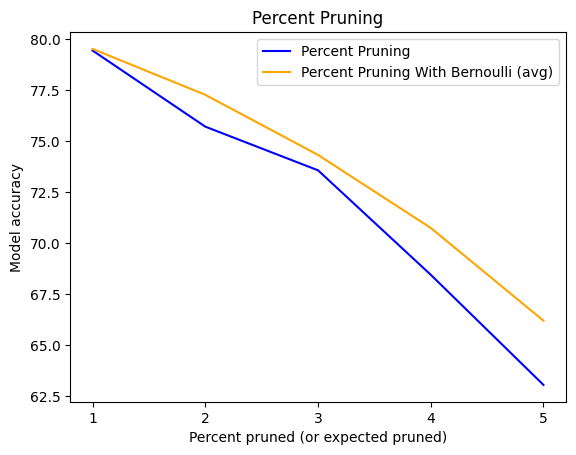

In [6]:
import matplotlib.pyplot as plt
import numpy as np

percents = np.arange(1,6,1)

fig, ax = plt.subplots()
ax.set_title("Percent Pruning")
line1, = ax.plot(percents, percent_prune, color='blue')
line2, = ax.plot(percents, percent_prune_with_bernoulli, color='orange')
line1.set_label("Percent Pruning")
line2.set_label("Percent Pruning With Bernoulli (avg)")
ax.legend()
ax.set_xlabel("Percent pruned (or expected pruned)")
ax.set_ylabel("Model accuracy")
ax.set_xticks(percents)
fig.show()


/var/folders/r0/g630ksd54rzd5q60gtr3_k0w0000gn/T/ipykernel_95900/4192906960.py:21: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


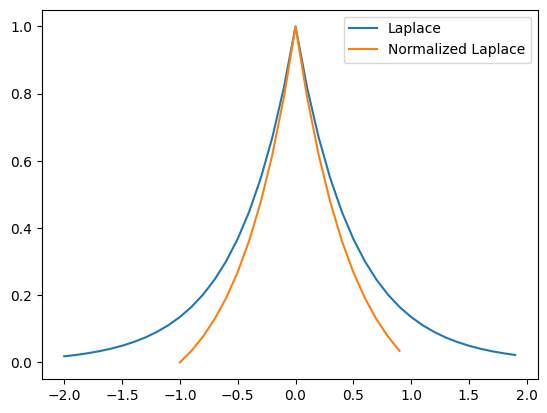

In [7]:
# Graph Laplace Distribution
import numpy as np
import matplotlib.pyplot as plt

loc=0
scale=0.5

x = np.arange(-2, 2, 0.1)

pdf = np.exp(-abs(x-loc)/scale)/(2.*scale)
new_min = np.exp(-abs(1.-loc)/scale)/(2.*scale)
x2 = np.arange(-1, 1, 0.1)
modified_pdf = (np.exp(-abs(x2-loc)/scale)/(2.*scale) - np.exp(-abs(1.-loc)/scale)/(2.*scale)) / (1-new_min)

fig, ax = plt.subplots()
line1, = ax.plot(x, pdf)
line1.set_label('Laplace')
line2, = ax.plot(x2, modified_pdf)
line2.set_label('Normalized Laplace')
ax.legend()
fig.show()


In [8]:
%load_ext autoreload
%autoreload now
import pruning_funcs

pruned_model = copy.deepcopy(model)
pruning_funcs.laplace_prune(pruned_model, device)
evaluate_model(pruned_model, testloader)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Accuracy of the model on the test images: 10.0%


10.0